In [10]:
import torch


torch.cuda.set_device(0)
device = torch.device("cuda")

In [11]:
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
dataset = ImageFolder("trafic_32", transform=transform)

train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
train_subset, valid_subset = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

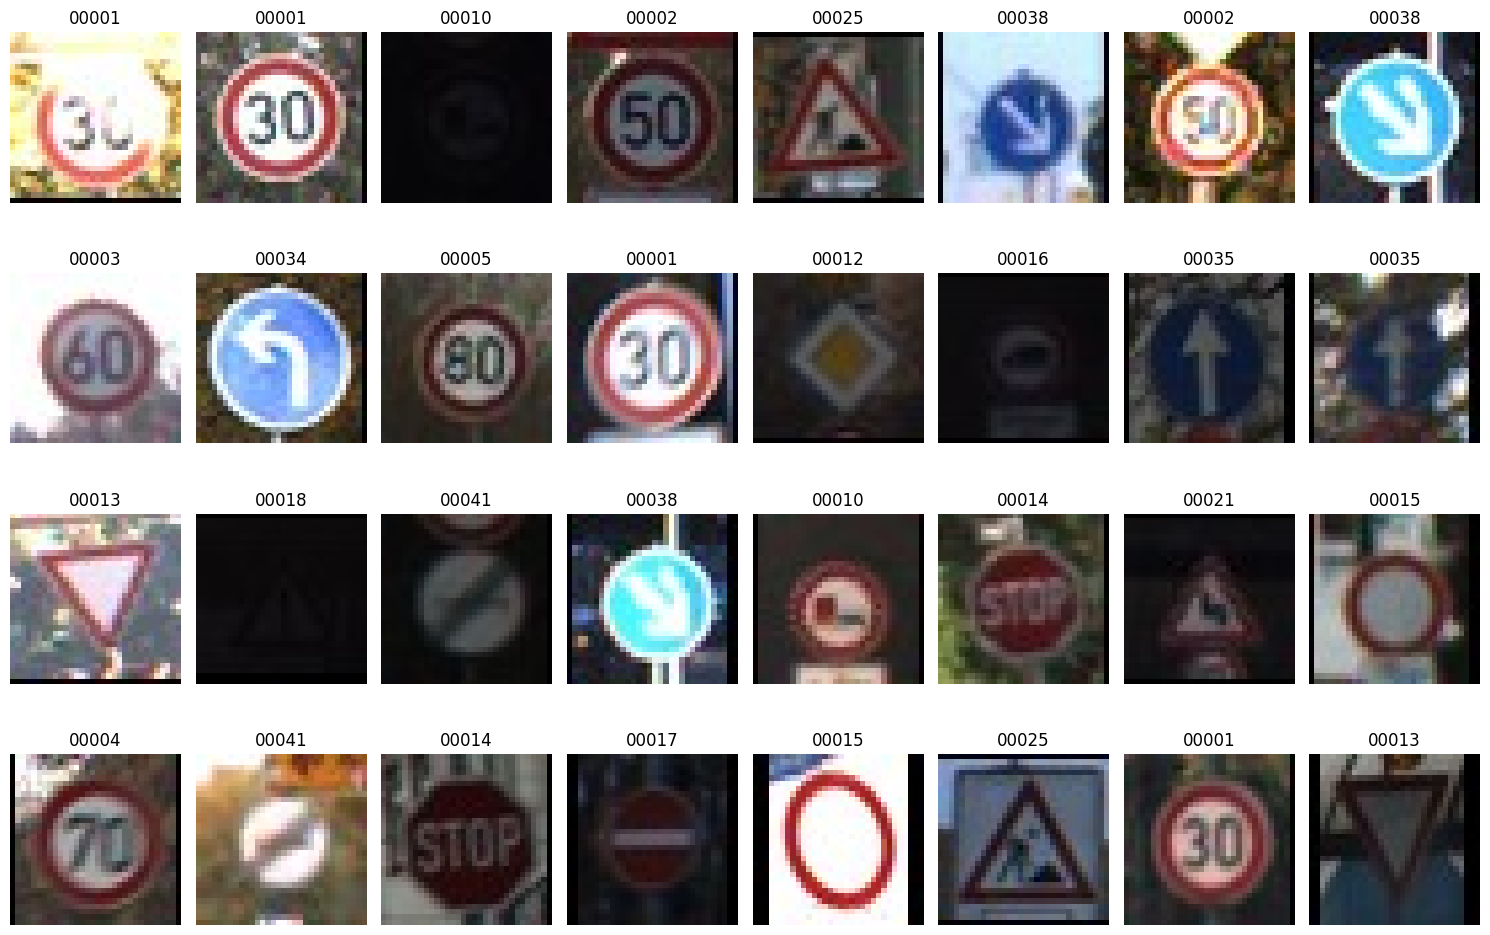

In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


class_names = dataset.classes

# Get one batch of images and labels from the trainloader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Unnormalize the images for display
images = images * 0.5 + 0.5  # Reverse normalization

# Create a grid of images
grid_size = (4, 8)  # 4 rows and 8 columns
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot each image in the grid
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.permute(1, 2, 0))  # Convert from CHW to HWC
    ax.set_title(class_names[label])  # Display the class name
    ax.axis("off")

# Hide any unused subplots
for ax in axes[len(images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
import torch.nn as nn


class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalDiscriminator, self).__init__()

        # Use an embedding layer to expand label info to image size
        self.label_embedding = nn.Linear(num_classes, 32 * 32)

        self.net = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),    # Input: 3+1 channels
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # x: [B, 3, 32, 32]
        # labels: [B, num_classes]
        label_map = self.label_embedding(labels).view(-1, 1, 32, 32)  # [B, 1, 32, 32]
        x_cond = torch.cat([x, label_map], dim=1)                     # [B, 4, 32, 32]
        return self.net(x_cond)                                       # [B, 1]

In [14]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(ConditionalGenerator, self).__init__()
        input_dim = latent_dim + num_classes

        self.fc = nn.Linear(input_dim, 512 * 4 * 4)

        self.net = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, 4, 2, 1),   # 8x8 → 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 16x16 → 32x32
            nn.Tanh()
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)                  # [B, latent+class]
        h = self.fc(x).view(-1, 512, 4, 4)                 # [B, 512, 4, 4]
        x_hat = self.net(h)                                # [B, 3, 32, 32]
        return x_hat

In [15]:
import torch.optim as optim


# Models
latent_dim = 256
num_classes = 43
conditional_generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes).to(device)
conditional_discriminator = ConditionalDiscriminator(num_classes=num_classes).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(conditional_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(conditional_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.BCELoss()

In [16]:
import torch.nn.functional as F


fixed_noise = torch.randn(16, latent_dim,device=device)
fixed_labels_one_hot = F.one_hot(torch.arange(16, device=device), num_classes=43).float()

In [17]:
print(fixed_labels_one_hot.shape)

torch.Size([16, 43])


Epoch: 0, discrimiantor fake error: 0.0597, discriminator real acc: 0.939
Epoch: 0, generator error: 2.74, discriminator error: 0.203


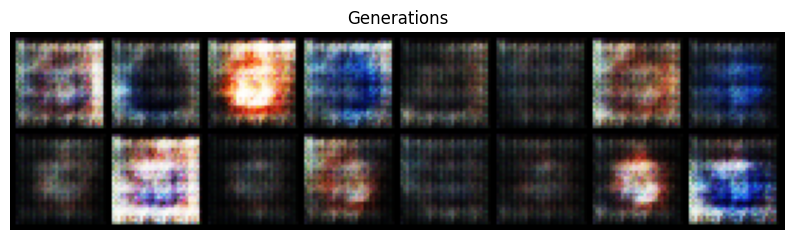

Epoch: 1, discrimiantor fake error: 0.0411, discriminator real acc: 0.959
Epoch: 1, generator error: 5.37, discriminator error: 0.0262
Epoch: 2, discrimiantor fake error: 0.0447, discriminator real acc: 0.955
Epoch: 2, generator error: 12.8, discriminator error: 0.178
Epoch: 3, discrimiantor fake error: 0.0398, discriminator real acc: 0.96
Epoch: 3, generator error: 10.4, discriminator error: 6.26e-05
Epoch: 4, discrimiantor fake error: 0.0365, discriminator real acc: 0.964
Epoch: 4, generator error: 6.09, discriminator error: 1.69e-09
Epoch: 5, discrimiantor fake error: 0.0391, discriminator real acc: 0.961
Epoch: 5, generator error: 9.76, discriminator error: 0.000534
Epoch: 6, discrimiantor fake error: 0.0421, discriminator real acc: 0.958
Epoch: 6, generator error: 0.00418, discriminator error: 0.000164
Epoch: 7, discrimiantor fake error: 0.0387, discriminator real acc: 0.962
Epoch: 7, generator error: 26.4, discriminator error: 0.000364
Epoch: 8, discrimiantor fake error: 0.0334, 

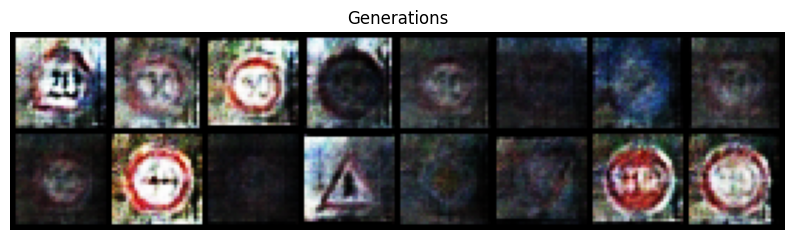

Epoch: 11, discrimiantor fake error: 0.026, discriminator real acc: 0.974
Epoch: 11, generator error: 1.88, discriminator error: 1.4
Epoch: 12, discrimiantor fake error: 0.033, discriminator real acc: 0.967
Epoch: 12, generator error: 0.0268, discriminator error: 1.98e-05
Epoch: 13, discrimiantor fake error: 0.0266, discriminator real acc: 0.973
Epoch: 13, generator error: 0.476, discriminator error: 0.00582
Epoch: 14, discrimiantor fake error: 0.0317, discriminator real acc: 0.969
Epoch: 14, generator error: 13.7, discriminator error: 1.62e-06
Epoch: 15, discrimiantor fake error: 0.0331, discriminator real acc: 0.967
Epoch: 15, generator error: 28.1, discriminator error: 0.0134
Epoch: 16, discrimiantor fake error: 0.0313, discriminator real acc: 0.97
Epoch: 16, generator error: 18.9, discriminator error: 4.87
Epoch: 17, discrimiantor fake error: 0.0337, discriminator real acc: 0.965
Epoch: 17, generator error: 12.6, discriminator error: 9.04e-05
Epoch: 18, discrimiantor fake error: 0.

In [18]:
import numpy as np


G_losses = []
D_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):
        if i % 1 == 0:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            discriminator_optimizer.zero_grad()
            real_images, real_labels = data[0].to(device), data[1].to(device) # get also the labels
            real_labels_one_hot = F.one_hot(real_labels, num_classes=43).float() # convert to one-hot encoding
            b_size = real_images.size(0)
            label = torch.ones((b_size,), dtype=torch.float, device=device)
            output = conditional_discriminator(real_images, real_labels_one_hot).view(-1) # use conditional discriminator
            error_discriminator_real = criterion(output, label)
            discriminator_real_acc.append(output.mean().item())

            noise = torch.randn(b_size, latent_dim,device=device)
            random_labels = torch.randint(0, num_classes, (b_size,), device=device)  # Generate random labels
            random_labels_one_hot = F.one_hot(random_labels, num_classes=num_classes).float()  # One-hot encode the labels
            fake_images = conditional_generator(noise, random_labels_one_hot) # use conditional generator
            label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
            output = conditional_discriminator(fake_images.detach(), random_labels_one_hot).view(-1) # use conditional discriminator
            error_discriminator_fake = criterion(output, label_fake)
            discriminator_fake_acc.append(output.mean().item())
            error_discriminator = error_discriminator_real + error_discriminator_fake
            error_discriminator.backward()
            discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        noise = torch.randn(b_size, latent_dim, device=device)
        random_labels = torch.randint(0, num_classes, (b_size,), device=device)  # Generqate random labels
        random_labels_one_hot = F.one_hot(random_labels, num_classes=num_classes).float()  # One-hot encode the labels
        fake_images = conditional_generator(noise, random_labels_one_hot) # use conditional generator
        label = torch.ones((b_size,), dtype=torch.float, device=device)
        output = conditional_discriminator(fake_images, random_labels_one_hot).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    print(f"Epoch: {epoch}, generator error: {error_generator.item():.3}, discriminator error: {error_discriminator.item():.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = conditional_generator(fixed_noise, fixed_labels_one_hot).detach().cpu()
        fake = (fake + 1) / 2
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

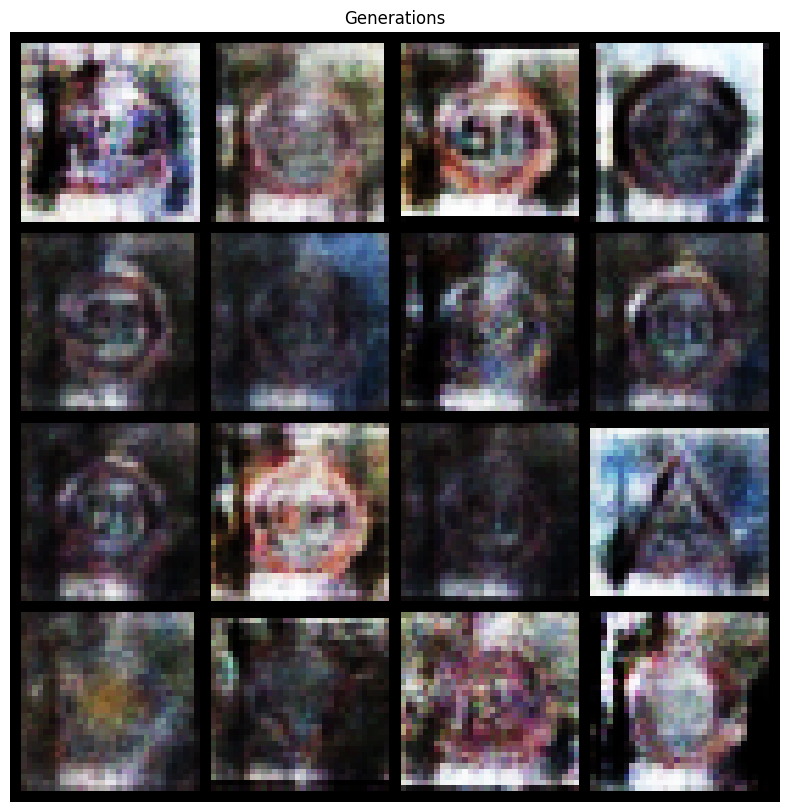

In [19]:
with torch.no_grad():
    fake = conditional_generator(fixed_noise, fixed_labels_one_hot).detach().cpu()
grid = torchvision.utils.make_grid(fake, nrow=4, normalize=True)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()

In [21]:
with torch.no_grad():
    fixed_labels_one_hot = F.one_hot(torch.arange(1000, device=device) % 43, num_classes=43).float()
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    generations_gan = conditional_generator(fixed_noise, fixed_labels_one_hot).detach().cpu()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
orig_data = torch.stack([x[0] for x in list(valid_subset)[:1000]])
orig_data = orig_data.view(-1, 3*32*32)

In [ ]:
from evaluator import Evaluator

device = torch.device("cuda")


evaluator = Evaluator(3*32*32, 512).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))
evaluator.eval()

with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from fid import calculate_frechet_distance

for name, obj in zip(['orig','gan'],[dist_orig_data.numpy(),dist_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

NameError: name 'dist_orig_data' is not defined

In [ ]:
torch.save(conditional_generator.state_dict(), "cond_conv_gan.pth")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
